In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import gillespy2
import dask
import copy
import json
import time
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from tsfresh.feature_extraction.settings import MinimalFCParameters
from dask.distributed import Client
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared
from sciope.inference.abc_inference import ABC

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model for data generation

In [3]:
# Use the model definition below
class Vilar_Oscillator(gillespy2.Model):
    def __init__(self, parameter_values=None):
        gillespy2.Model.__init__(self, name="Vilar_Oscillator")
        self.volume = 1

        # Parameters
        self.add_parameter(gillespy2.Parameter(name="alpha_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="alpha_a_prime", expression=500))
        self.add_parameter(gillespy2.Parameter(name="alpha_r", expression=0.01))
        self.add_parameter(gillespy2.Parameter(name="alpha_r_prime", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_r", expression=5))
        self.add_parameter(gillespy2.Parameter(name="delta_ma", expression=10))
        self.add_parameter(gillespy2.Parameter(name="delta_mr", expression=0.5))
        self.add_parameter(gillespy2.Parameter(name="delta_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="delta_r", expression=0.2))
        self.add_parameter(gillespy2.Parameter(name="gamma_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_r", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_c", expression=2))
        self.add_parameter(gillespy2.Parameter(name="theta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="theta_r", expression=100))

        # Species
        self.add_species(gillespy2.Species(name="Da", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Ma", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Mr", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="C", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="A", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="R", initial_value=10, mode="discrete"))

        # Reactions
        self.add_reaction(gillespy2.Reaction(name="r1", reactants={'Da_prime': 1}, products={'Da': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r2", reactants={'Da': 1, 'A': 1}, products={'Da_prime': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(gillespy2.Reaction(name="r3", reactants={'Dr_prime': 1}, products={'Dr': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r4", reactants={'Dr': 1, 'A': 1}, products={'Dr_prime': 1}, rate=self.listOfParameters["gamma_r"]))
        self.add_reaction(gillespy2.Reaction(name="r5", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r6", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(gillespy2.Reaction(name="r7", reactants={'Ma': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(gillespy2.Reaction(name="r8", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate=self.listOfParameters["beta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r9", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r10", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r11", reactants={'A': 1}, products={}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r12", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r13", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r14", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(gillespy2.Reaction(name="r15", reactants={'Mr': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate=self.listOfParameters["beta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r17", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r18", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 201))

In [4]:
vilar_model = Vilar_Oscillator()

In [4]:
def configure_simulation():
    solver = gillespy2.SSACSolver(model=vilar_model)
    kwargs = {
        "solver":solver,
        "number_of_trajectories":1,
        # "seed":None,
        # "tau_tol":0.03,
        # "integrator_options":{'rtol': 0.001, 'atol': 1e-06},
    }
    return kwargs

In [5]:
kwargs = configure_simulation()
fixed_data = vilar_model.run(**kwargs)
fixed_data.plotplotly()

## Prior Distribution

In [5]:
default_param = np.array(list(vilar_model.listOfParameters.items()))[:, 1]

bound = []
for exp in default_param:
    bound.append(float(exp.expression))

# Set the bounds
bound = np.array(bound)
dmin = bound * 0.1
dmax = bound * 2.0

# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

In [6]:
N = 100
samples_delayed = uni_prior.draw(N)
samples ,= dask.compute(samples_delayed)
samples = np.asarray(samples)
samples = samples.reshape(N, len(bound))

## Simulator

In [13]:
parameter_names = ['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 'beta_a', 'beta_r', 'delta_ma',
                    'delta_mr', 'delta_a', 'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r']

solver = gillespy2.solvers.SSACSolver(model=vilar_model)

def sim_vilar(params, model=vilar_model):
    res = model.run(
            number_of_trajectories = 2,
            solver = solver,
            variables = {parameter_names[i] : np.asarray(params[i]) for i in range(len(parameter_names))})

    tot_res = np.zeros((len(res), 3, len(res[0]['C'])))
    for i in range(len(res)):
        tot_res[i, 0, :] = res[i]['C']
        tot_res[i, 1, :] = res[i]['A']
        tot_res[i, 2, :] = res[i]['R']

    return tot_res

In [14]:
params = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])

In [15]:
sim_vilar(params=params)

array([[[ 10.,  82., 337., ..., 236., 307., 256.],
        [ 10., 769., 894., ...,   0.,   1.,   0.],
        [ 10.,   0.,   1., ..., 960., 725., 653.]],

       [[ 10.,  71., 303., ..., 262., 232., 307.],
        [ 10., 872., 959., ...,   1.,   0.,   1.],
        [ 10.,   0.,   0., ..., 457., 421., 285.]]])

## Generating training samples based on prior distribution

In [16]:
responses = []
num_species = 3
num_timestamps = 201

for i in range(N):
    current_sample = np.squeeze(samples[i,:].reshape(1, len(samples[i,:])))
    lazy_response = dask.delayed(sim_vilar)(current_sample)
    responses.append(lazy_response)
    #print(i)

# dask compute
computed_responses ,= dask.compute(responses)

# get it in the right shape sciope shape - N x S x T
#ts = np.asarray(computed_responses)
#ts = ts.reshape(N, num_species, num_timestamps)

In [102]:
dic = {}
dic['c'], dic['a'], dic['r'] = [], [], []
for i in range(len(computed_responses)):
    for j in range(len(computed_responses[0])):
        dic['c'].append(list(computed_responses[i][j][0]))
        dic['a'].append(list(computed_responses[i][j][1]))
        dic['r'].append(list(computed_responses[i][j][2]))

# save the data into json
#with open("100_100_data.json", "w") as file:
    #json.dump(dic, file)

## Normalization

In [3]:
with open("100_100_data.json", "r") as file:
    data = json.load(file)

def normalize_data(d, new, min_max):
    for j in d:
        i = np.array(j)
        new.append((np.array(i) - np.min(i)) / (np.max(i) - np.min(i)))
        min_max.append([np.min(i), np.max(i)])

n_c, n_a, n_r, m_c, m_a, m_r = [], [], [], [], [], []
normalize_data(data['c'], n_c, m_c)
normalize_data(data['a'], n_a, m_a)
normalize_data(data['r'], n_r, m_r)

## Calculate variance of each species as noise

In [4]:
def var(lst, N=100):
    if N != 1:
        v = []
        chunk_size = len(lst) // N
        chunks = [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]
        for chunk in chunks:
            v.append(np.mean(np.var(chunk, axis=0)))
        return np.mean(v, axis=0)

    else:
        return np.mean(np.var(lst, axis=0))

var_c = var(n_c)
var_a = var(n_a)
var_r = var(n_r)
print(var_c, var_a, var_r)

0.03825498409446312 0.05183072132564281 0.0706826068419877


## Pre-processing data to fit in the model

In [5]:
All_data, C, A, R = [], [], [], []
for i in range(len(n_c)):
    data = []
    data.append([n_c[i], [var_c], m_c[i]])
    data.append([n_a[i], [var_a], m_a[i]])
    data.append([n_r[i], [var_r], m_r[i]])
    All_data.append(data)

In [6]:
train_df, df = train_test_split(
    All_data,
    test_size = 0.1,
    random_state = RANDOM_SEED
)

val_df, test_df = train_test_split(
    df,
    test_size = 0.5,
    random_state = RANDOM_SEED
)

In [7]:
def create_dataset(df):
    dataset = []
    for i in df:
        c = torch.tensor(i[0][0].tolist()).float()
        a = torch.tensor(i[1][0].tolist()).float()
        r = torch.tensor(i[2][0].tolist()).float()
        v = torch.tensor([np.mean(np.array([i[0][1][0], i[1][1][0], i[2][1][0]]))]).float()
        dataset.append([c, a, r, v])
    
    #seq_len, n_features = np.array(dataset[0][0]).shape[0], np.array(dataset[0]).shape[0]
    return dataset

In [8]:
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)

In [10]:
print(len(All_data))
print(len(train_dataset[0]))
print(train_dataset[0][0].shape)
print(train_dataset[0][3].shape)

10000
4
torch.Size([201])
torch.Size([1])


## Autoencoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, seq_len=201, n_features=3, latent_dim=16):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features, self.latent_dim = seq_len, n_features, latent_dim

        self.conv1 = nn.Conv1d(n_features, 1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(seq_len, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.relu(self.fc1(x))
        y = self.relu(self.fc2(y))
        y = self.relu(self.fc3(y))
        y = self.relu(self.fc4(y))
        y = self.conv1(y)
        return y

In [10]:
class Decoder(nn.Module):
    def __init__(self, seq_len=201, input_dim=16, n_features=3):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim, self.n_features = seq_len, input_dim, n_features

        self.conv1 = nn.ConvTranspose1d(1, n_features, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, seq_len)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu(self.fc1(y))
        y = self.relu(self.fc2(y))
        y = self.relu(self.fc3(y))
        y = self.relu(self.fc4(y))
        return y

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, seq_len=201, n_features=3, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, latent_dim).to(device)
        self.decoder = Decoder(seq_len, latent_dim, n_features).to(device)

    def forward(self, x):
        c, a, r, v = torch.split(x, [201, 201, 201, 1], dim=0)
        x = torch.tensor([c.tolist(), a.tolist(), r.tolist()]).to(device)
        y = self.encoder(x)
        y = torch.add(y, v).to(device)
        y = self.decoder(y)
        return y

In [50]:
#model = Autoencoder(seq_len, n_features)
model = Autoencoder()
model = model.to(device)

## Model training

In [51]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        model = model.train()
        train_losses = []
        for seq in train_dataset:
            optimizer.zero_grad()
            seq = torch.cat(seq, dim=0).to(device)
            seq_pred = model(seq).to(device)
            c, a, r, v = torch.split(seq, [201, 201, 201, 1], dim=0)
            seq_true = torch.tensor([c.tolist(), a.tolist(), r.tolist()]).to(device)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq in val_dataset:
                seq = torch.cat(seq, dim=0).to(device)
                seq_pred = model(seq).to(device)
                c, a, r, v = torch.split(seq, [201, 201, 201, 1], dim=0)
                seq_true = torch.tensor([c.tolist(), a.tolist(), r.tolist()]).to(device)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if (early_stop_counter >= 10) and (val_loss-best_loss >= 1):
                print(f'Early stopping at epoch {epoch}')
                break

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        print('time: ', time.time()-start_time)

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [52]:
model, history = train_model(
    model, 
    train_dataset, 
    val_dataset, 
    n_epochs = 50
)
torch.save(model, 'model1.pth')

Epoch 1: train loss 24.103286902180425 val loss 19.90499163500468
time:  54.61266303062439
Epoch 2: train loss 18.943853632926942 val loss 18.263057692845663
time:  55.28583312034607
Epoch 3: train loss 17.188121073864124 val loss 16.63583218765259
time:  55.338484048843384
Epoch 4: train loss 16.192214424839726 val loss 15.692442101796468
time:  54.77870202064514
Epoch 5: train loss 15.574138446666577 val loss 15.17072098604838
time:  52.74247217178345
Epoch 6: train loss 14.900287238262317 val loss 14.42607436243693
time:  51.95160889625549
Epoch 7: train loss 14.433511428409153 val loss 14.193392866770427
time:  54.532721757888794
Epoch 8: train loss 14.085358755924084 val loss 13.73077058537801
time:  55.62768912315369
Epoch 9: train loss 13.817572553316753 val loss 13.515471020380655
time:  53.24532198905945
Epoch 10: train loss 13.567189871152243 val loss 13.360274869918824
time:  51.82785892486572
Epoch 11: train loss 13.346141917581912 val loss 13.056883661905925
time:  54.3660

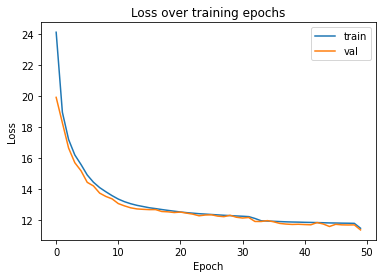

In [53]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show()

## Test

In [14]:
model = torch.load('history/fnn_100_100.pth') 

nor_prediction, nor_true, de_prediction, de_true = [], [], [], []
for i in range(len(test_dataset)):
    seq = torch.cat(test_dataset[i], dim=0).to(device)
    seq_pred = model(seq)
    c, a, r, v = torch.split(seq, [201, 201, 201, 1], dim=0)
    seq_true = torch.tensor([c.tolist(), a.tolist(), r.tolist()])
    prediction = np.squeeze(seq_pred.detach().numpy())
    true = np.squeeze(seq_true.detach().numpy())
    for j in range(len(true)):
        nor_true.append(true[j].tolist())
        de_true.append(np.array(true[j]) * (test_df[i][j][-1][1] - test_df[i][j][-1][0]) + test_df[i][j][-1][0])
    for k in range(len(prediction)):
        nor_prediction.append(prediction[k].tolist())
        de_prediction.append(np.array(prediction[k]) * (test_df[i][k][-1][1] - test_df[i][k][-1][0]) + test_df[i][k][-1][0])

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


## Euclidean Distance and MAPE

In [15]:
def calc_euclidean(actual, predic):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(actual, predic):
    return np.mean(np.abs((actual - predic) / actual))

euclidean, mape = [], []
euclidean = [calc_euclidean(de_true[i], de_prediction[i]) for i in range(len(de_true))]
nor_eucl = (np.array(euclidean) - np.min(euclidean)) / (np.max(euclidean) - np.min(euclidean))
mape = [calc_mape(de_true[i], de_prediction[i]) for i in range(len(de_true))]

/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_2033/59302362.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - predic) / actual))
/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_2033/59302362.py:5: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - predic) / actual))


## Pearson Correlation Coefficient

In [16]:
def calc_pearson(actual, predic):
    a_diff = actual - np.mean(actual)
    p_diff = predic - np.mean(predic)
    numerator = np.sum(a_diff * p_diff)
    denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
    return numerator / denominator

pearson = []
pearson = [calc_pearson(de_true[i], de_prediction[i]) for i in range(len(de_true))]

In [16]:
print(np.mean(nor_eucl), np.mean(pearson))

0.4265465 0.8544109


In [21]:
import seaborn as sns

def plot_fig(l):
    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
    for i in range(len(l)):
        if i == 0 or i ==2 or i ==4:
            a = 0
        else:
            a = 2

        if i == 0 or i == 1:
            b = 0
            s = 'c'
        elif i == 2 or i == 3:
            b = 1
            s = 'a'
        else:
            b = 2
            s = 'r'

        axs[b, a].plot(de_true[l[i]], label='Original')
        axs[b, a].plot(de_prediction[l[i]], label='Predicted')
        axs[b, a].fill_between(np.arange(201), de_true[l[i]], de_prediction[l[i]], color='green', alpha=0.3)
        axs[b, a].set_xlabel(f"Test Sample: {l[i]}, Species: {s}")
        axs[b, a].legend()
        #axs[b, a].set_title(f'Eucl: {nor_eucl[l[i]]:.2f}, MAPE: {mape[l[i]]:.2f}')
        axs[b, a].set_title(f'Eucl: {nor_eucl[l[i]]:.2f}')
        axs[b, a+1].scatter(de_true[l[i]], de_prediction[l[i]])
        axs[b, a+1].plot([np.min(de_true[l[i]]), np.max(de_true[l[i]])], [np.min(de_true[l[i]]), np.max(de_true[l[i]])], 'k-', linewidth=3, color = 'r')
        axs[b, a+1].set_title(f"Pearson Correlation: {pearson[l[i]]:.2f}")
        axs[b, a+1].set_xlabel("Original")
        axs[b, a+1].set_ylabel("Predicted")
    plt.show()

/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_2033/2294192131.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[b, a+1].plot([np.min(de_true[l[i]]), np.max(de_true[l[i]])], [np.min(de_true[l[i]]), np.max(de_true[l[i]])], 'k-', linewidth=3, color = 'r')
/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_2033/2294192131.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[b, a+1].plot([np.min(de_true[l[i]]), np.max(de_true[l[i]])], [np.min(de_true[l[i]]), np.max(de_true[l[i]])], 'k-', linewidth=3, color = 'r')
/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_2033/2294192131.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take p

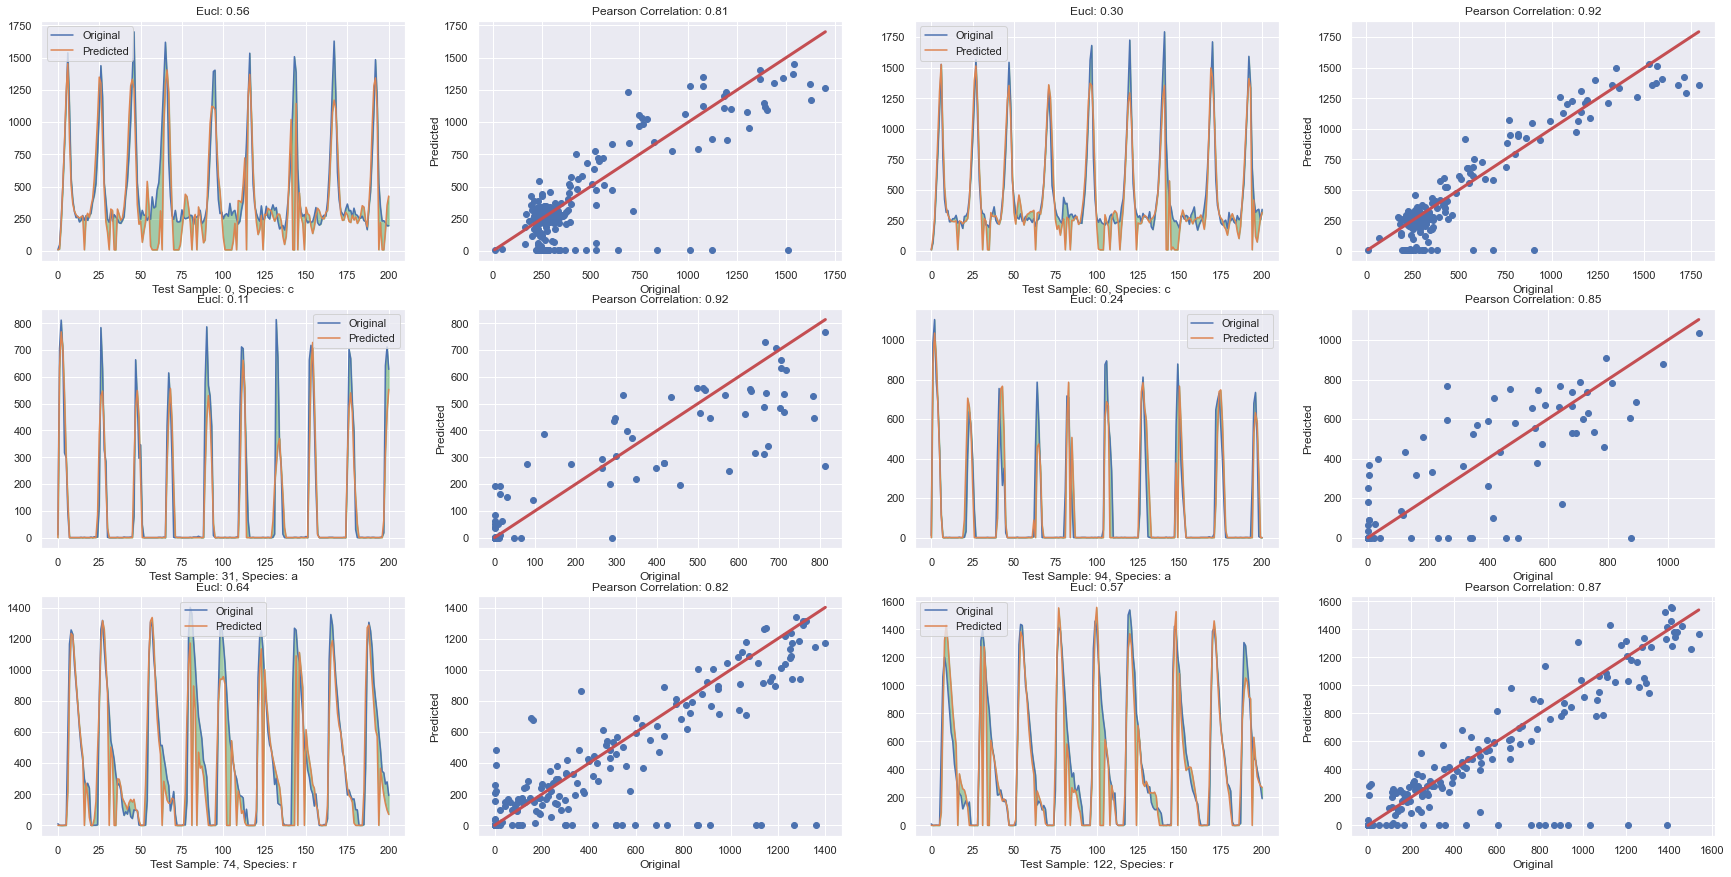

In [25]:
l = [0, 60, 31, 94, 74, 122]
plot_fig(l)

## Dynamic Time Warping

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

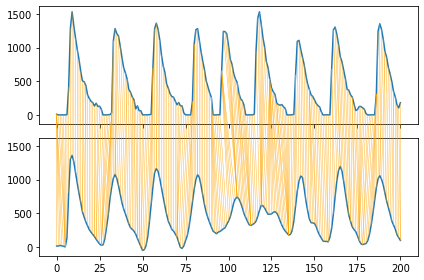

In [23]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

#distance = []
#distance = [dtw.distance(de_true[1], de_prediction[1]) for i in range(len(de_true))]

path = dtw.warping_path(de_true[1], de_prediction[1])
dtwvis.plot_warping(de_true[1], de_prediction[1], path)

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

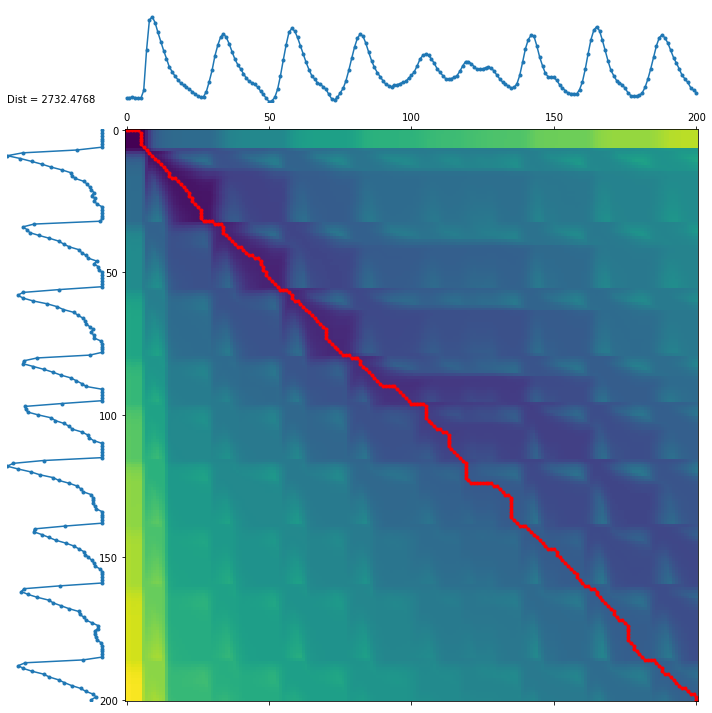

In [24]:
d, paths = dtw.warping_paths(de_true[1], de_prediction[1])
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(de_true[1], de_prediction[1], paths, best_path)

## Compression-based dissimilarity

In [39]:
import bz2
import numpy as np

class CompressionBasedDissimilarity(object):

    def __init__(self, n_letters=7):
        self.bins = None
        self.n_letters = n_letters

    def set_bins(self, bins):
        self.bins = bins

    def sax_bins(self, all_values):
        bins = np.percentile(
            all_values[all_values > 0], np.linspace(0, 100, self.n_letters + 1)
        )
        bins[0] = 0
        bins[-1] = 1e1000
        return bins

    @staticmethod
    def sax_transform(all_values, bins):
        indices = np.digitize(all_values, bins) - 1
        alphabet = np.array([*("abcdefghijklmnopqrstuvwxyz"[:len(bins) - 1])])
        text = "".join(alphabet[indices])
        return str.encode(text)

    def calculate(self, m, n):
        if self.bins is None:
            m_bins = self.sax_bins(m)
            n_bins = self.sax_bins(n)
        else:
            m_bins = n_bins = self.bins
        m = self.sax_transform(m, m_bins)
        n = self.sax_transform(n, n_bins)
        len_m = len(bz2.compress(m))
        len_n = len(bz2.compress(n))
        len_combined = len(bz2.compress(m + n))
        return len_combined / (len_m + len_n)

In [40]:
cbd = CompressionBasedDissimilarity()
print(cbd.calculate(de_true[1], de_prediction[1]))

0.7722772277227723
